In [1]:
# Cell 1: Import & cấu hình

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# Lấy thư mục gốc Project (cha của Notebook, Module, Model, ...)
current_dir = os.getcwd()
project_root_dir = os.path.dirname(current_dir)

if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

# Import pipeline
from Module.Load_Data import CleanDataLoader

# Import model dự báo theo môn
from Model.Forecast.ForecastSubjectModel import ForecastModel, build_ml_df


In [2]:
# ===== EXPORT SETUP (dán ngay sau cell setup/import) =====
from pathlib import Path
import re

# project_root_dir / project_root đã có trong notebook của bạn
# EDA + Forecast: đang có project_root_dir
# ChangePoint: đang có project_root
try:
    _ROOT = Path(project_root_dir)
except NameError:
    _ROOT = Path(project_root)

# tìm folder Report/report cho chắc
REPORT_DIR = _ROOT / "Report"
if not REPORT_DIR.exists():
    REPORT_DIR = _ROOT / "report"

ASSETS_DIR = REPORT_DIR / "assets"
FIG_DIR = ASSETS_DIR / "figures"
TAB_DIR = ASSETS_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

# đặt prefix theo notebook (SỬA MỖI NOTEBOOK 1 LẦN)
RUN_TAG = "eda"          # đổi: "changepoint" / "forecast"

def _safe(name: str) -> str:
    return re.sub(r"[^0-9a-zA-Z_-]+", "_", name).strip("_").lower()

def save_fig(name: str, fig=None, formats=("png", "pdf"), dpi=300):
    import matplotlib.pyplot as plt
    if fig is None:
        fig = plt.gcf()
    out = []
    for ext in formats:
        p = FIG_DIR / f"{RUN_TAG}_{_safe(name)}.{ext}"
        fig.savefig(p, dpi=dpi, bbox_inches="tight")
        out.append(p)
    print("✅ saved fig:", ", ".join(map(str, out)))
    return out

def save_table(df, name: str, index=False, also_tex=True):
    csv_path = TAB_DIR / f"{RUN_TAG}_{_safe(name)}.csv"
    df.to_csv(csv_path, index=index, encoding="utf-8-sig")
    print("✅ saved table:", csv_path)

    tex_path = None
    if also_tex:
        try:
            tex_path = TAB_DIR / f"{RUN_TAG}_{_safe(name)}.tex"
            tex_path.write_text(df.to_latex(index=index), encoding="utf-8")
            print("✅ saved tex:", tex_path)
        except Exception as e:
            print("⚠️ to_latex failed:", e)

    return csv_path, tex_path


### 3.1. Dự báo điểm trung bình năm 2026 theo môn

#### 3.1.1. Mục tiêu

- Xây dựng mô hình dự báo **điểm trung bình** các môn thi chính (Toán, Ngữ văn, Ngoại ngữ, các môn tổ hợp) cho năm 2026.
- Xem xét tác động của **“điểm gãy 2025”** lên quỹ đạo điểm trung bình theo thời gian.
- So sánh nhiều mô hình (baseline tuyến tính, mô hình ML/Time-series) và chọn ra kịch bản dự báo hợp lý.


In [3]:
# Cell 3: Khởi tạo loader dữ liệu sạch

clean_data = CleanDataLoader(project_root=project_root_dir)
print("Block root:", clean_data.block_data_root)
print("Subject root:", clean_data.subject_data_root)


Block root: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Clean_Data_2023-2025\Block_Data
Subject root: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Clean_Data_2023-2025\Subject_Data


In [4]:
# Cell 4: Xây dựng Map chọn môn học
subject_map = {
    1: "toan",
    2: "ngu_van",
    3: "vat_li",
    4: "hoa_hoc",
    5: "sinh_hoc",
    6: "tin_hoc",
    7: "cn_cong_nghiep",
    8: "cn_nong_nghiep",
    9: "lich_su",
    10: "dia_li",
    11: "gdcd",
    12: "ngoai_ngu",
}

print("=== Danh sách môn học ===")
for k, v in subject_map.items():
    print(f"{k}: {v}")


=== Danh sách môn học ===
1: toan
2: ngu_van
3: vat_li
4: hoa_hoc
5: sinh_hoc
6: tin_hoc
7: cn_cong_nghiep
8: cn_nong_nghiep
9: lich_su
10: dia_li
11: gdcd
12: ngoai_ngu


In [5]:
# Cell 5: Chuẩn bị dataframe cho mô hình dự báo theo môn

# 1. Lấy distribution & analysis theo môn từ CleanDataLoader
dist_list = []
anal_list = []

for sid, subj in subject_map.items():
    # ----- DISTRIBUTION -----
    df_dist = clean_data.get_subject_data(
        subject=subj,
        kind="distribution"
    ).copy()

    # Chuẩn hoá tên cột cho distribution
    df_dist = df_dist.rename(columns={
        "nam_hoc": "year",
        "tong_diem": "score",
        "so_hoc_sinh": "count",
    })
    df_dist["subject"] = subj
    df_dist = df_dist.loc[:, ~df_dist.columns.duplicated()]  # tránh trùng cột
    dist_list.append(df_dist)

    # ----- ANALYSIS -----
    df_anal = clean_data.get_subject_data(
        subject=subj,
        kind="analysis"
    ).copy()

    if "nam_hoc" in df_anal.columns:
        df_anal = df_anal.rename(columns={"nam_hoc": "year"})
    df_anal["subject"] = subj
    anal_list.append(df_anal)

# Gộp distribution & analysis
df_distribution = pd.concat(dist_list, ignore_index=True)
summary_df = pd.concat(anal_list, ignore_index=True)

# Chuẩn hoá analysis: chỉ giữ các cột cần
summary_df_std = summary_df.rename(columns={
    "mean": "mean_score",
    "median": "median_score",
}).copy()

summary_df_std = summary_df_std[[
    "year", "subject", "mean_score", "median_score", "std", "min", "max"
]].copy()

print("summary_df_std:")
display(summary_df_std.head())


summary_df_std:


,year,subject,mean_score,median_score,std,min,max
0,2018,toan,4.853,5.000,1.469,0.000,10.000
1,2019,toan,5.635,5.800,1.740,0.000,10.000
2,2020,toan,6.662,7.000,1.819,0.000,10.000
3,2021,toan,6.637,7.000,1.674,0.600,10.000
4,2022,toan,6.466,6.800,1.675,0.000,10.000


In [16]:
# 1. Chuẩn hóa distribution dataframe
df_dist_std = df_distribution.rename(columns={
    "nam_hoc": "year",
    "diem": "score",
    "so_hoc_sinh": "count"
})

# 2. Tổng số thí sinh
total_students = (
    df_dist_std
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_students"})
)

# 3. Số thí sinh ≥ 5
ge_5 = (
    df_dist_std[df_dist_std["score"] >= 5]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_5"})
)

# 4. Số thí sinh ≥ 8
ge_8 = (
    df_dist_std[df_dist_std["score"] >= 8]
    .groupby(["year", "subject"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "n_ge_8"})
)

# 5. Gộp
df_rates = (
    total_students
    .merge(ge_5, on=["year", "subject"], how="left")
    .merge(ge_8, on=["year", "subject"], how="left")
)

# 6. Fill missing
df_rates[["n_ge_5", "n_ge_8"]] = df_rates[["n_ge_5", "n_ge_8"]].fillna(0)

# 7. Tính tỉ lệ
df_rates["rate_ge_5"] = df_rates["n_ge_5"] / df_rates["n_students"]
df_rates["rate_ge_8"] = df_rates["n_ge_8"] / df_rates["n_students"]

df_rates = df_rates[[
    "year", "subject", "rate_ge_5", "rate_ge_8"
]]

# 8. Build df_ml (vẫn dùng hàm trong ForecastSubjectModel)
df_ml = build_ml_df(summary_df_std, df_rates)
print(df_ml)


    year         subject  mean_score  median_score   std   min    max  \
0   2025  cn_cong_nghiep       5.793         5.600 1.540 2.300 10.000   
1   2025  cn_nong_nghiep       7.716         7.750 1.171 1.550 10.000   
2   2018          dia_li       5.463         5.500 1.272 0.000 10.000   
3   2019          dia_li       5.996         6.000 1.226 0.000 10.000   
4   2020          dia_li       6.773         7.000 1.172 0.000 10.000   
..   ...             ...         ...           ...   ...   ...    ...   
70  2021          vat_li       6.566         6.750 1.393 0.000 10.000   
71  2022          vat_li       6.724         7.000 1.442 0.000 10.000   
72  2023          vat_li       6.574         6.750 1.487 0.000 10.000   
73  2024          vat_li       6.667         7.000 1.631 0.000 10.000   
74  2025          vat_li       6.978         7.000 1.522 0.000 10.000   

    post_2025  delta_score  mean_prev  is_first_year  rate_ge_5  rate_ge_8  
0           1        0.000      0.000         

In [7]:
# Cell 7: Đánh giá mô hình trên năm 2025

forecast_model = ForecastModel(df_ml)

# Năm dùng để evaluate (giống logic cũ: dùng năm mới nhất làm test)
year_test = forecast_model.year_for_test
print("Năm dùng để đánh giá:", year_test)

print("\n=== Kết quả ARIMA (scenario raw) ===")
arima_raw_2025 = forecast_model.evaluate_arima(scenario="raw")
display(arima_raw_2025)

print("\n=== Kết quả ARIMAX (scenario post_2025) ===")
arima_post_2025 = forecast_model.evaluate_arima(scenario="post")
display(arima_post_2025)

print("\n=== Kết quả RF-global (scenario raw) ===")
rf_raw_2025 = forecast_model.evaluate_rf(scenario="raw")
display(rf_raw_2025)

print("\n=== Kết quả XGB-global (scenario post_2025) ===")
xgb_post_2025 = forecast_model.evaluate_xgb(scenario="post")
display(xgb_post_2025)


Năm dùng để đánh giá: 2025

=== Kết quả ARIMA (scenario raw) ===
[ARIMA 9 subject] MAE (2025) = 0.3593


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
0,dia_li,6.643,6.654,0.011,0.011,0.169
1,gdcd,7.692,8.042,0.351,0.351,4.562
2,hoa_hoc,6.070,6.502,0.432,0.432,7.125
3,lich_su,6.515,6.255,0.260,0.260,3.984
4,ngoai_ngu,5.406,5.226,0.180,0.180,3.331
5,ngu_van,6.990,6.983,0.007,0.007,0.101
6,sinh_hoc,5.781,5.804,0.023,0.023,0.403
7,toan,4.800,6.284,1.484,1.484,30.917
8,vat_li,6.978,6.493,0.485,0.485,6.950



=== Kết quả ARIMAX (scenario post_2025) ===
[ARIMAX 9 subject] MAE (2025) = 0.3593


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
0,dia_li,6.643,6.654,0.011,0.011,0.169
1,gdcd,7.692,8.042,0.351,0.351,4.562
2,hoa_hoc,6.070,6.502,0.432,0.432,7.125
3,lich_su,6.515,6.255,0.260,0.260,3.984
4,ngoai_ngu,5.406,5.226,0.180,0.180,3.331
5,ngu_van,6.990,6.983,0.007,0.007,0.101
6,sinh_hoc,5.781,5.804,0.023,0.023,0.403
7,toan,4.800,6.284,1.484,1.484,30.917
8,vat_li,6.978,6.493,0.485,0.485,6.950



=== Kết quả RF-global (scenario raw) ===
[RF-global-raw 12 subject] MAE (2025) = 0.1454


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
0,cn_cong_nghiep,5.793,5.544,0.249,0.249,4.290
1,cn_nong_nghiep,7.716,7.725,0.009,0.009,0.120
9,dia_li,6.643,6.622,0.021,0.021,0.309
17,gdcd,7.692,7.566,0.125,0.125,1.630
25,hoa_hoc,6.070,5.520,0.550,0.550,9.060
33,lich_su,6.515,6.564,0.050,0.050,0.761
41,ngoai_ngu,5.406,5.517,0.110,0.110,2.041
49,ngu_van,6.990,6.821,0.169,0.169,2.425
57,sinh_hoc,5.781,5.560,0.221,0.221,3.819
58,tin_hoc,6.783,6.725,0.057,0.057,0.845



=== Kết quả XGB-global (scenario post_2025) ===
[XGB-global-post 12 subject] MAE (2025) = 0.1423


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
0,cn_cong_nghiep,5.793,5.615,0.178,0.178,3.065
1,cn_nong_nghiep,7.716,7.278,0.437,0.437,5.669
9,dia_li,6.643,6.551,0.092,0.092,1.389
17,gdcd,7.692,7.396,0.296,0.296,3.842
25,hoa_hoc,6.070,6.024,0.046,0.046,0.757
33,lich_su,6.515,6.559,0.044,0.044,0.670
41,ngoai_ngu,5.406,5.339,0.068,0.068,1.252
49,ngu_van,6.990,6.841,0.150,0.150,2.143
57,sinh_hoc,5.781,5.684,0.096,0.096,1.665
58,tin_hoc,6.783,6.685,0.098,0.098,1.446


In [ ]:
# Cell 8: Dự báo điểm trung bình 2026 bằng XGB + khoảng tin cậy

df_forecast = forecast_model.forecast_2026_xgb(
    alpha=0.05,
    scenario="post"
)

print("Bảng forecast điểm trung bình 2018–2026:")
display(df_forecast)

print("\nDự báo riêng cho năm 2026:")
display(df_forecast[df_forecast["year"] == df_forecast["year"].max()])


[XGB-global-post 9 subject] MAE (2025) = 0.3127
[XGB-global-post 9 subject] MAE (2025) = 0.4884
[XGB-global-post 9 subject] MAE (2025) = 0.1676
[XGB-global-post 9 subject] MAE (2025) = 0.1266
[XGB-global-post 9 subject] MAE (2025) = 0.1403
[XGB-global-post 9 subject] MAE (2025) = 0.0851
[XGB-global-post 12 subject] MAE (2025) = 0.1423
Bảng forecast điểm trung bình 2023–2026:


,subject,year,mean_actual,mean_predicted,lower_CI,upper_CI
0,cn_cong_nghiep,2025,5.793,5.615,5.356,5.874
1,cn_nong_nghiep,2025,7.716,7.278,7.019,7.538
2,dia_li,2019,5.996,5.513,5.235,5.790
3,dia_li,2020,6.773,6.082,5.568,6.595
4,dia_li,2021,6.965,6.885,6.560,7.210
...,...,...,...,...,...,...
61,vat_li,2021,6.566,6.709,6.384,7.034
62,vat_li,2022,6.724,6.699,6.349,7.049
63,vat_li,2023,6.574,6.583,6.292,6.874
64,vat_li,2024,6.667,6.660,6.405,6.915



Dự báo riêng cho năm 2026:


,subject,year,mean_actual,mean_predicted,lower_CI,upper_CI
0,cn_cong_nghiep,2025,5.793,5.615,5.356,5.874
1,cn_nong_nghiep,2025,7.716,7.278,7.019,7.538
8,dia_li,2025,6.643,6.551,6.291,6.810
15,gdcd,2025,7.692,7.396,7.137,7.655
22,hoa_hoc,2025,6.070,6.024,5.765,6.283
29,lich_su,2025,6.515,6.559,6.299,6.818
36,ngoai_ngu,2025,5.406,5.339,5.079,5.598
43,ngu_van,2025,6.990,6.841,6.581,7.100
50,sinh_hoc,2025,5.781,5.684,5.425,5.944
51,tin_hoc,2025,6.783,6.685,6.425,6.944


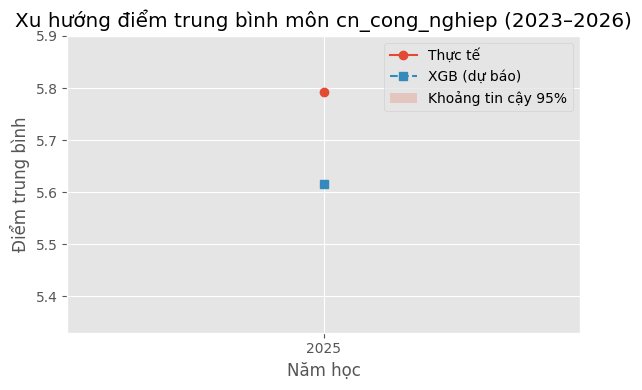

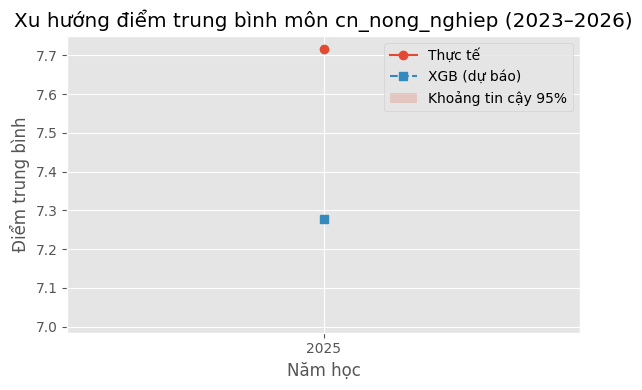

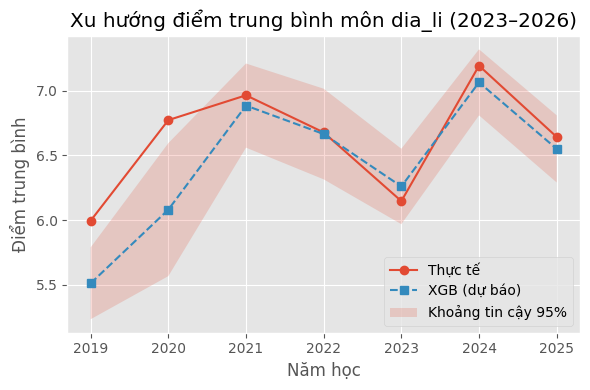

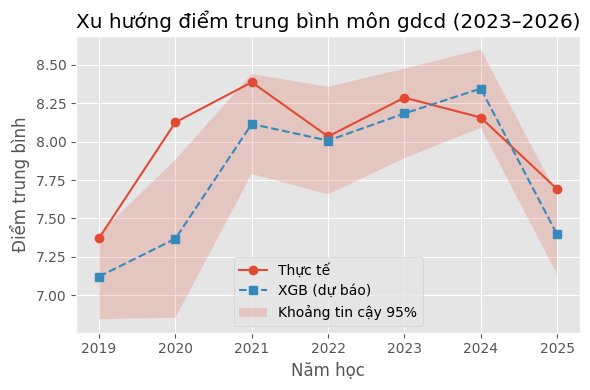

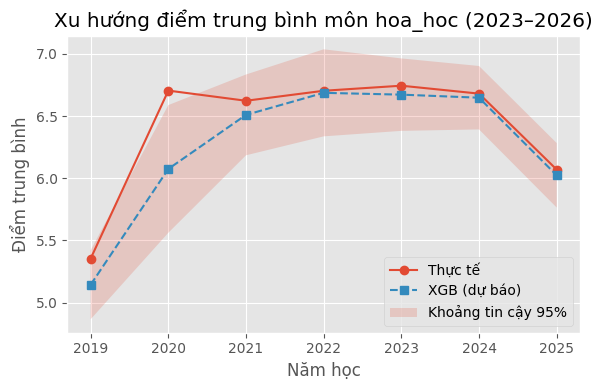

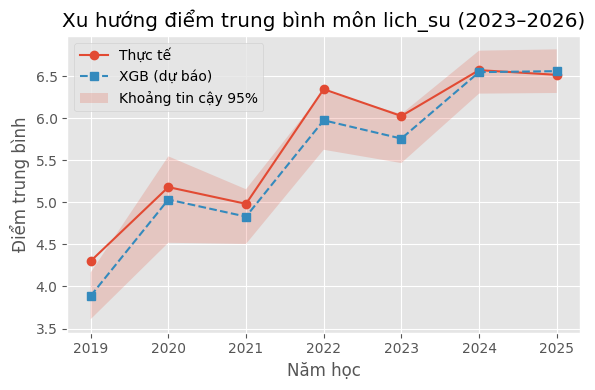

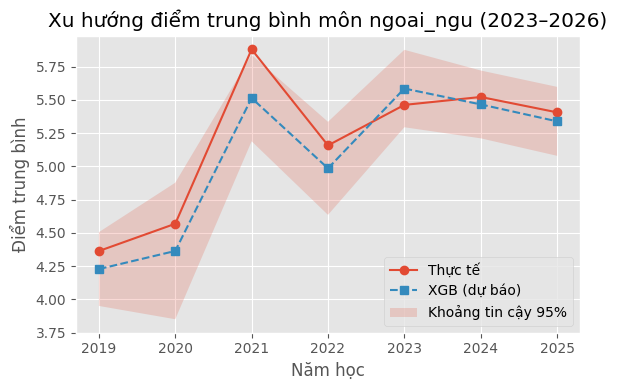

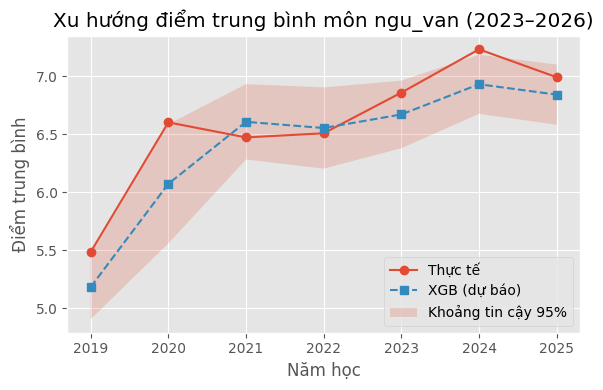

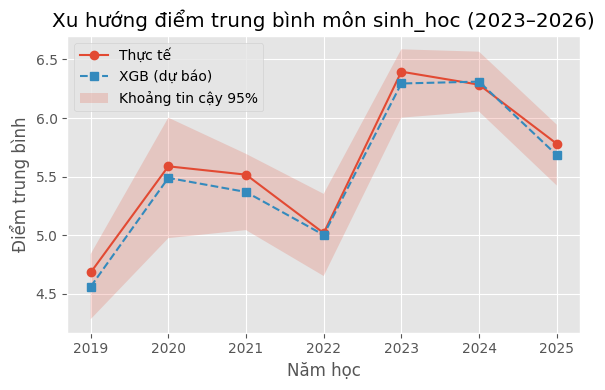

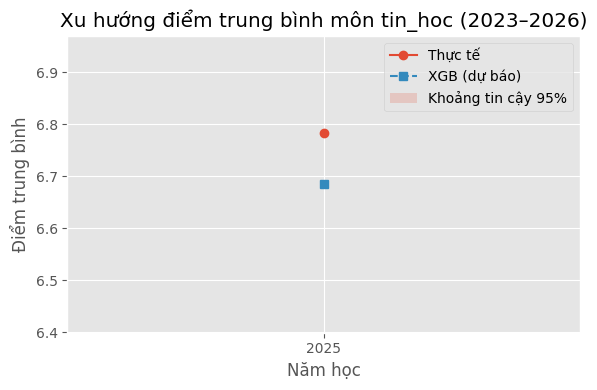

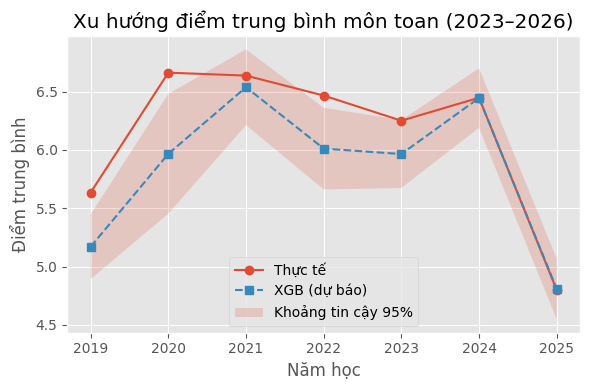

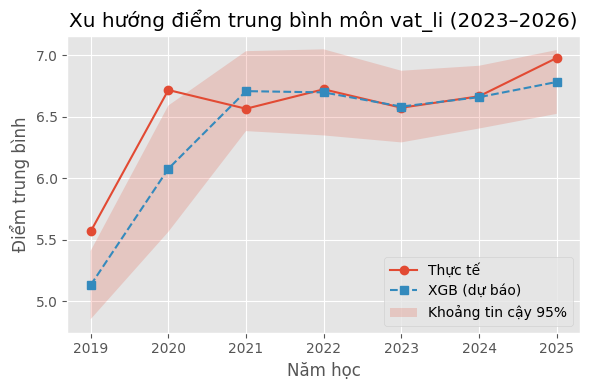

In [9]:
# Cell 9: Trực quan hoá theo từng môn — thực tế vs XGB + forecast 2026

subjects = sorted(df_forecast["subject"].unique())

for subj in subjects:
    df_sub = df_forecast[df_forecast["subject"] == subj].copy()
    df_sub = df_sub.sort_values("year")

    plt.figure(figsize=(6, 4))

    # 1) Điểm thực tế (chỉ có tới 2025)
    df_actual = df_sub[~df_sub["mean_actual"].isna()]
    if not df_actual.empty:
        plt.plot(
            df_actual["year"],
            df_actual["mean_actual"],
            marker="o",
            label="Thực tế",
        )

    # 2) Dự báo XGB (2023–2026)
    plt.plot(
        df_sub["year"],
        df_sub["mean_predicted"],
        marker="s",
        linestyle="--",
        label="XGB (dự báo)",
    )

    # 3) Vùng khoảng tin cậy (nếu có)
    if {"lower_CI", "upper_CI"}.issubset(df_sub.columns):
        plt.fill_between(
            df_sub["year"],
            df_sub["lower_CI"],
            df_sub["upper_CI"],
            alpha=0.2,
            label="Khoảng tin cậy 95%",
        )

    plt.title(f"Xu hướng điểm trung bình môn {subj} (2023–2026)")
    plt.xlabel("Năm học")
    plt.ylabel("Điểm trung bình")
    plt.xticks(sorted(df_sub["year"].unique()))
    plt.legend()
    plt.tight_layout()
    plt.show()


Năm dùng để so sánh: 2024


,subject,mean_actual,mean_predicted
0,gdcd,8.157,8.345
1,ngu_van,7.231,6.930
2,dia_li,7.194,7.065
3,hoa_hoc,6.681,6.648
4,vat_li,6.667,6.660
5,lich_su,6.570,6.547
6,toan,6.447,6.445
7,sinh_hoc,6.284,6.310
8,ngoai_ngu,5.522,5.466


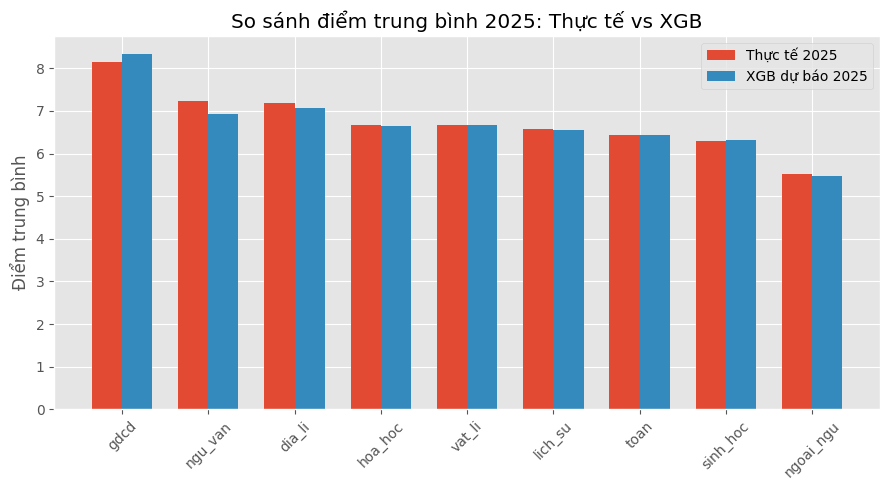

In [10]:
# Cell 10: So sánh điểm trung bình năm 2025 — Thực tế vs XGB

year_test = df_forecast["year"].max() - 1  # nếu 2026 là forecast, 2025 là năm test
print("Năm dùng để so sánh:", year_test)

df_2025 = df_forecast[df_forecast["year"] == year_test].copy()
df_2025 = df_2025[["subject", "mean_actual", "mean_predicted"]].dropna()

df_2025 = df_2025.sort_values("mean_actual", ascending=False).reset_index(drop=True)

display(df_2025)

# Bar chart
x = np.arange(len(df_2025))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(x - width/2, df_2025["mean_actual"], width, label="Thực tế 2025")
plt.bar(x + width/2, df_2025["mean_predicted"], width, label="XGB dự báo 2025")

plt.xticks(x, df_2025["subject"], rotation=45)
plt.ylabel("Điểm trung bình")
plt.title("So sánh điểm trung bình 2025: Thực tế vs XGB")
plt.legend()
plt.tight_layout()
plt.show()


### 3.2. Dự báo tỉ lệ tổ hợp khối thi năm 2026

- Tập trung vào 10 khối chính: A00, A01, B00, C00, D01, D07, D08, D09, A02, A03.
- Xây dựng bảng feature theo năm–khối, bao gồm:
  - share_in_year, year_idx, share_lag1, delta_share, post_2025, ...
- So sánh nhiều mô hình (baseline LinearGD, Multi-REG, ARIMA) trên năm 2025.
- Chọn top-2 mô hình tốt nhất (giữa Multi-REG & ARIMA) để dự báo tỉ lệ năm 2026.


In [11]:
# Cell 10: Hàm load toàn bộ block analysis thành dataframe feature

import pandas as pd
from pathlib import Path
from Module.Load_Data import CleanDataLoader

def load_all_block_analysis_with_features(
    clean_data: CleanDataLoader,
) -> pd.DataFrame:
    """
    - Đọc toàn bộ Export_Analysis_<BLOCK>.csv và Export_Distribution_<BLOCK>.csv
      từ Block_Data để tạo bảng feature cho train.
    - Chuẩn hoá:
        + nam_hoc: int
        + khoi: tên khối (A00, A01, ...)
        + n_students, mean, median, std, ...
        + total_students_year: tổng số thí sinh toàn năm
    """

    block_root: Path = clean_data.block_data_root
    if not block_root.exists():
        raise FileNotFoundError(f"Block_Data folder không tồn tại: {block_root}")

    all_dfs = []

    folder_prefix = clean_data._block_data_f_prefix + "_"   # "CleanData_"

    for sub in block_root.iterdir():
        if not sub.is_dir():
            continue
        if not sub.name.startswith(folder_prefix):
            continue

        block_name = sub.name.replace(folder_prefix, "")

        # analysis
        anal_path = sub / f"Export_Analysis_{block_name}.csv"
        dist_path = sub / f"Export_Distribution_{block_name}.csv"

        if not anal_path.exists() or not dist_path.exists():
            continue

        df_anal = pd.read_csv(anal_path)
        df_dist = pd.read_csv(dist_path)

        if "nam_hoc" not in df_anal.columns:
            raise ValueError("Export_Analysis_* phải có cột 'nam_hoc'.")

        df_anal["khoi"] = block_name

        # tổng số thí sinh theo năm-khối từ distribution
        df_dist_group = (
            df_dist
            .groupby(["nam_hoc"], as_index=False)["so_hoc_sinh"]
            .sum()
            .rename(columns={"so_hoc_sinh": "n_students"})
        )

        df_merged = df_anal.merge(
            df_dist_group,
            on="nam_hoc",
            how="left"
        )

        all_dfs.append(df_merged)

    if not all_dfs:
        raise ValueError("Không tìm thấy dữ liệu block analysis nào.")

    block_analysis_all = pd.concat(all_dfs, ignore_index=True)

    # Tổng thí sinh toàn năm từ clean_data
    df_total = clean_data.get_total_students().copy()

    if "nam_hoc" not in df_total.columns:
        raise ValueError(
            "DataFrame từ get_total_students() phải có cột 'nam_hoc'."
        )

    # Map tên cột cho đúng với file Export_Yearly_Total_Students.csv
    # File này dùng 'total_students', ta đổi sang 'total_students_year' cho thống nhất.
    if "total_students_year" not in df_total.columns:
        if "total_students" in df_total.columns:
            df_total = df_total.rename(columns={"total_students": "total_students_year"})
        else:
            raise ValueError(
                "DataFrame tổng số thí sinh phải có cột 'total_students' hoặc 'total_students_year'."
            )

    block_analysis_all = block_analysis_all.merge(
        df_total[["nam_hoc", "total_students_year"]],
        on="nam_hoc",
        how="left"
    )
    
    return block_analysis_all


In [12]:
# Cell 11: Load toàn bộ block feature

clean_data = CleanDataLoader(project_root=project_root_dir)

df_block_features = load_all_block_analysis_with_features(clean_data=clean_data)
print("df_block_features:")
display(df_block_features.head())


df_block_features:


,nam_hoc,mean,median,mode,std,min,max,khoi,n_students,total_students_year
0,2018,15.556,15.650,16.050,3.691,0.000,29.050,A00,382744,921520
1,2019,17.728,18.150,19.550,3.848,0.000,29.050,A00,333194,882557
2,2020,21.447,21.900,23.200,3.343,0.900,29.750,A00,291252,870486
3,2021,20.999,21.400,22.750,3.198,4.050,29.550,A00,323261,914558
4,2022,21.096,21.450,22.750,3.238,5.100,30.000,A00,323673,995435


In [13]:
from Model.Forecast.ForecastBlockModel import ForecastBlockModel

forecast_block = ForecastBlockModel(
    df_block_features=df_block_features,
    year_test=2025,
)

df_mae_2025 = forecast_block.compare_models_2025()
display(df_mae_2025)


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔎 So sánh MAE năm 2025 giữa các model:
                 model_display  MAE_2025
0                  ARIMA share     0.039
1         Linear-GD (baseline)     0.049
2  Multi-REG (Ridge + softmax)     0.077
👉 Top-2 model dùng cho forecast 2026: ['ARIMA', 'MultiShareReg']


,model_id,model_display,MAE_2025
0,ARIMA,ARIMA share,0.039
1,LinearGD,Linear-GD (baseline),0.049
2,MultiShareReg,Multi-REG (Ridge + softmax),0.077


In [14]:
# Cell 13: Dự báo tỉ lệ khối năm 2026

df_block_share_2023_2026 = forecast_block.forecast_2026()

print("\nBảng share 2023–2026:")
display(df_block_share_2023_2026)

print("\nTỉ lệ share dự báo 2026:")
display(df_block_share_2023_2026[df_block_share_2023_2026["nam_hoc"] == 2026])


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Bảng share 2026 (final):
    nam_hoc khoi  share
8      2026  A00  0.085
17     2026  A01  0.084
26     2026  A02  0.077
31     2026  A03  0.049
40     2026  B00  0.077
49     2026  C00  0.141
58     2026  D01  0.151
67     2026  D07  0.151
76     2026  D08  0.074
85     2026  D09  0.111

Bảng share 2023–2026:


,nam_hoc,khoi,share
0,2018,A00,0.084
1,2019,A00,0.077
2,2020,A00,0.073
3,2021,A00,0.076
4,2022,A00,0.071
...,...,...,...
81,2022,D09,0.122
82,2023,D09,0.122
83,2024,D09,0.120
84,2025,D09,0.049



Tỉ lệ share dự báo 2026:


,nam_hoc,khoi,share
8,2026,A00,0.085
17,2026,A01,0.084
26,2026,A02,0.077
31,2026,A03,0.049
40,2026,B00,0.077
49,2026,C00,0.141
58,2026,D01,0.151
67,2026,D07,0.151
76,2026,D08,0.074
85,2026,D09,0.111


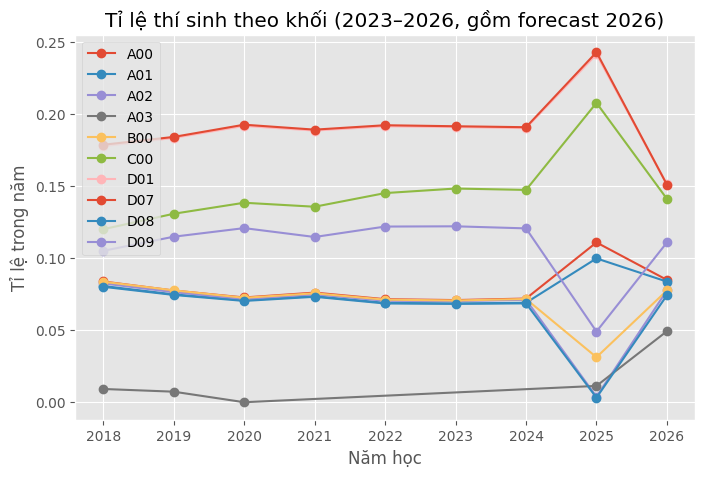

In [15]:
# Cell 14: Vẽ line chart share 2023–2026 theo khối

plt.figure(figsize=(8, 5))
for khoi, g in df_block_share_2023_2026.groupby("khoi"):
    plt.plot(g["nam_hoc"], g["share"], marker="o", label=khoi)

plt.title("Tỉ lệ thí sinh theo khối (2023–2026, gồm forecast 2026)")
plt.xlabel("Năm học")
plt.ylabel("Tỉ lệ trong năm")
plt.legend()
plt.show()
